In [2]:
%matplotlib inline

In [3]:
from candlestick import candlestick
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd

# Кратки бележки по проекта.



Целта на този проект е да представи пред широката публика анализ на някой от по-популярните технически индикатори и сигнали, които се ползват от начинаещите трейдъри, при търговията с финансови инструменти. Целевата аудитория, за която е предназначена е групата на хората без никакви основни познания за механизмите и начините на търговия с ценни книжа, а целта е да се предпазят тези хора от фалшив ентусиазъм и реална загуба на пари.

### 1. Структура на проекта

- Съдържанието на статия е поднесено във файл **Measuring_trading_strategies.pdf**
- Програмната част е отделена в папка **trading_strategies_code**, която има следната структура:

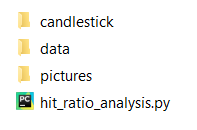

  1. Основната програмна логика се съдържа във файл __hit_ratio_analysis.py__

  2. Папка **candlestick** съдържа спомагателна библиотека за определяне на отделните модели от  кендъли. Библиотеката е взаимствана от ... , но се наложи допълнително дописване за да придобие необходимата за проекта функционалност. 

  3.Папка **data** съдържа .csv файлове със сурови данни за цените на ценните книжа на ТОП 20 компании от S&P 500 Stocks по тяхното индексно тегло. Ползвани са исторически данни за различните компании за периоди от 3 до 10 години, взети на дневна база.  Във файл **samples.xlsx** е изнесена справка с броя исторически записи за всяка наблюдавана компания. 
  
  4. Папка **pictures** съдържа графики, необходими за онагледяване на концепциите залегнали в проекта. Всички графики и диаграми се генерират автоматично в тази папка директно от кода. Малка част от тях са пренесени в статията. 


### 2. Описание на заданието


### TODO

### 3. Описание на кода

По-долу е описана програмната логика. 

а/ В кода са дефинирани предварително някой константи и обекти, които се ползват на различните етапи от изчисленията.

In [26]:
CHART_MIN = -200
CHART_MAX = -1
MARKERSIZE = 50
DOWN_INDICATOR = 0.98
UP_INDICATOR = 1.02
STOP_LEVEL = 0.02
STOP_LEVEL_LOST = 0.01
HOLDING_PERIOD = 5

# Top 20 S&P 500 Stocks by Index Weight
shares = {
    'Facebook, Inc. (FB)': 'FB.csv',
    'Moderna, Inc. (MRNA)': 'MRNA.csv',
    'Amazon.com, Inc. (AMZN)': 'AMZN.csv',
    'Alphabet Inc. (GOOG)': 'GOOG.csv',
    'Microsoft Corporation (MSFT)': 'MSFT.csv',
    'Apple Inc. (AAPL)': 'AAPL.csv',
    'Tesla, Inc. (TSLA)': 'TSLA.csv',
    'Berkshire Hathaway Inc. (BRK-B)': 'BRK.csv',
    'JPMorgan Chase & Co. (JPM)': 'JPM.csv',
    'Johnson & Johnson (JNJ)': 'JNJ.csv',
    "Visa Inc. (V)": "V.csv",
    "UnitedHealth Group Incorporated (UNH)": "UNH.csv",
    "NVIDIA Corporation (NVDA)": "NVDA.csv",
    "The Home Depot, Inc. (HD)": "HD.csv",
    "The Procter and Gamble Company (PG)": "PG.csv",
    "Mastercard Incorporated (MA)": "MA.csv",
    "Bank of America Corporation (BAC)": "BAC.csv",
    "PayPal Holdings, Inc. (PYPL)": "PYPL.csv",
    "Intel Corporation (INTC)": "INTC.csv",
    "Comcast Corporation (CMCSA)": "CMCSA.csv",
}

signals_parameters = {'BullishEngulfing': 'bull',
                      'BearishEngulfing': 'bear',
                      'EveningStar': 'bear',
                      'InvertedHammers': 'bull',
                      'Hammer': 'bull',
                      'MorningStar': 'bull'}

df_coefficients = {'BullishEngulfing': [],
                   'BearishEngulfing': [],
                   'EveningStar': [],
                   'InvertedHammers': [],
                   'Hammer': [],
                   'MorningStar': []}

signal_names = [k for k in signals_parameters.keys()]

mapper = {'BullishEngulfing': candlestick.bullish_engulfing,
          'BearishEngulfing': candlestick.bearish_engulfing,
          'EveningStar': candlestick.evening_star,
          'InvertedHammers': candlestick.inverted_hammer,
          'Hammer': candlestick.hammer,
          'MorningStar': candlestick.morning_star}

б/ Основната бизнес логика е заложена по-долу.

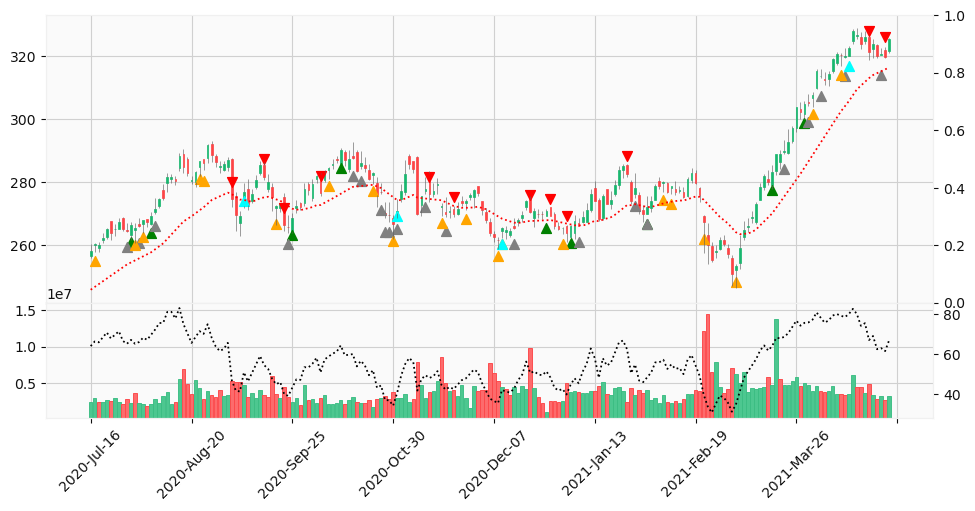

In [29]:
for company_name, data_file in shares.items():
    df = read_data_from_file(data_file)
    with open("data/samples.csv", "a") as fl:
        fl.write(f'{company_name}, {len(df)}\n')
    make_chart(df)
    for signal_name in signal_names:
        signal_coefficients = get_signal_coefficients(signal_name, df)
        df_coefficients[signal_name].append(signal_coefficients[0])

# plot_df_coefficients_histograms(df_coefficients)
# plot_hit_ratio(df_coefficients)

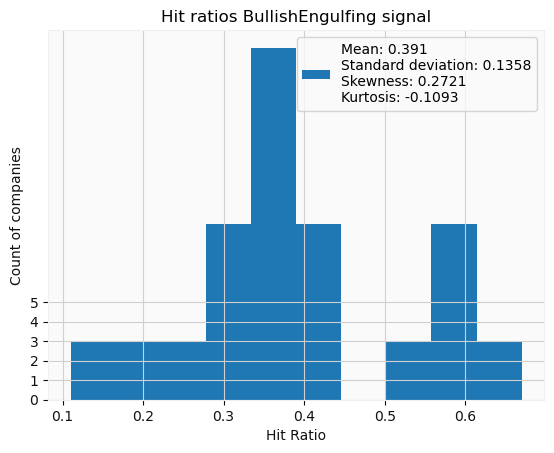

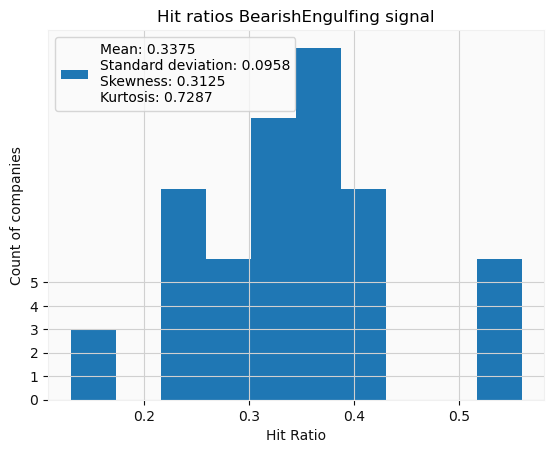

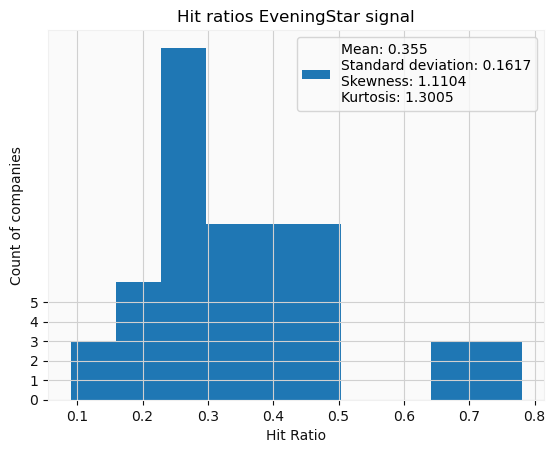

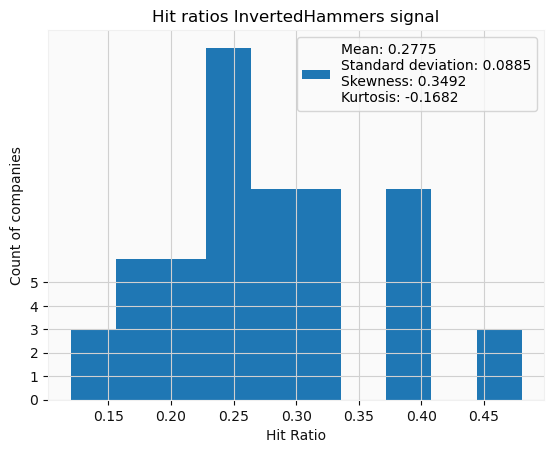

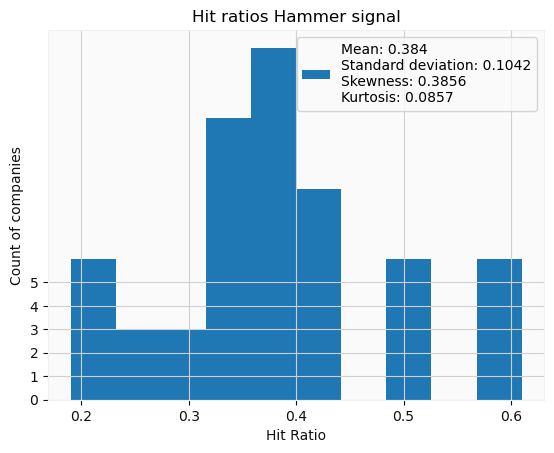

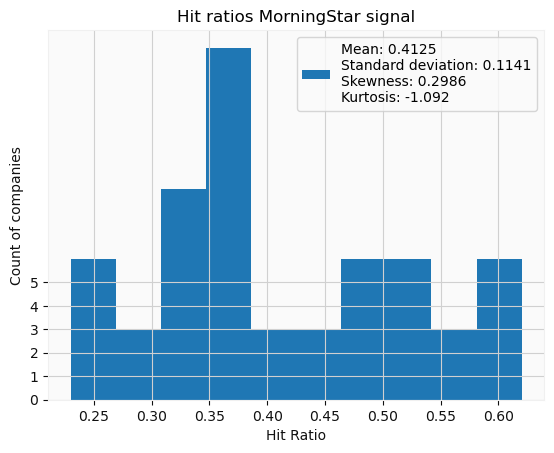

In [30]:
plot_df_coefficients_histograms(df_coefficients)


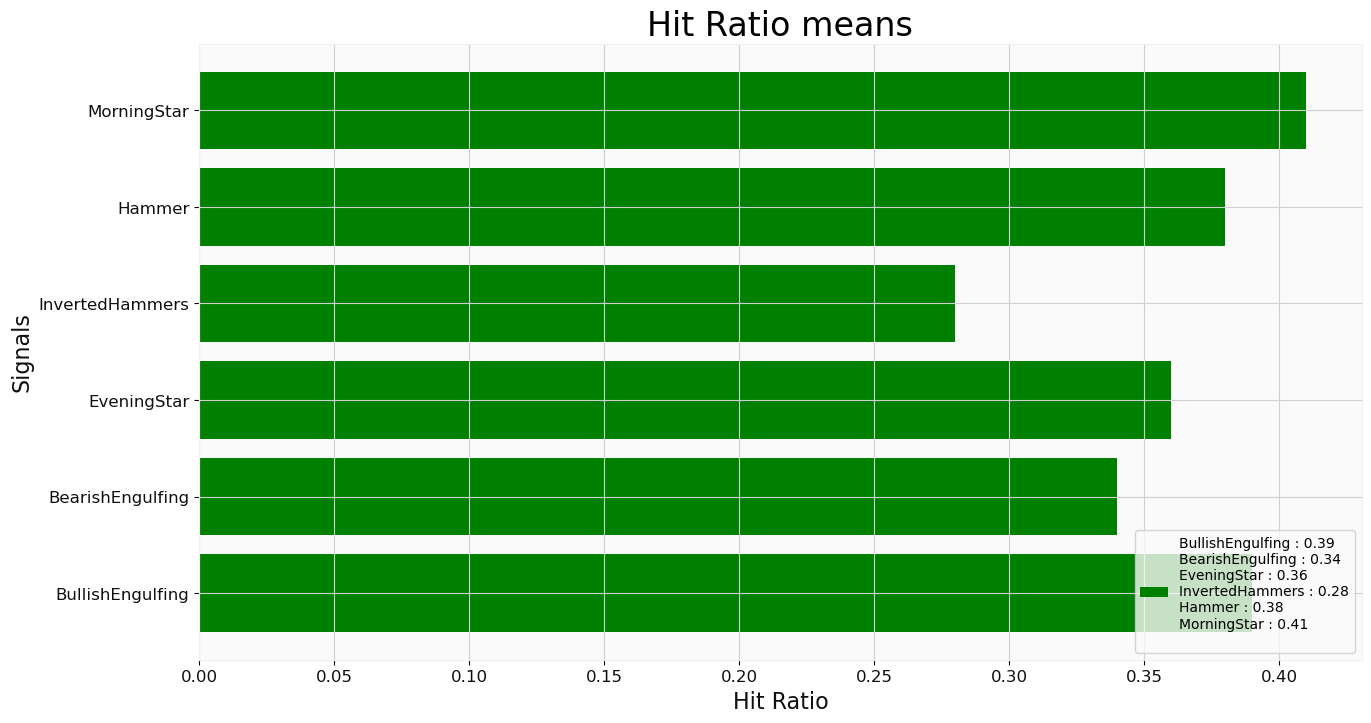

In [31]:
plot_hit_ratio(df_coefficients)

в/ Програмата стартира с четене на .csv файла за конкретната компания, след което данните се добавят в **pandas.DataFrame обект**. На този етап се изчисляват и добавят индикаторите EWM и RSI. Добавят се колони с генерираните сигнали - булеви стойности, съобщаващи наличието или липсата на сигнал за всяка разглеждана дата.
Функцията за четене на данните връща готовия за обработки обект.

In [6]:

def read_data_from_file(data_file):
    with open(f"data/{data_file}") as f:
        df = pd.read_csv(f, index_col=0, parse_dates=["date"])
    f.close()

    candles_df = pd.DataFrame(df,
                              columns=['T', 'open', 'high', 'low', 'close', 'volume', 'CT', 'QV', 'N', 'TB', 'TQ', 'I'])
    candles_df.index.name = 'date'

    # Add Exponential moving average EWM
    ewm_short = pd.DataFrame(df['adj close'].ewm(span=21, adjust=False).mean())
    candles_df['EWM'] = ewm_short

    # calculate Relative Strength Index (RSI)
    delta = df['adj close'].diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    ema_up = up.ewm(com=13, adjust=False).mean()
    ema_down = down.ewm(com=13, adjust=False).mean()
    rs = ema_up / ema_down

    candles_df['RSI'] = 100 - (100 / (1 + rs))

    # add signals column
    for t, f in mapper.items():
        target = t
        candles_df = f(candles_df, target=target)

    return candles_df
 

г/ Следващата стъпка е визуалното графичното представяне на обработените данни с функцията **make_chart(candles_df)**. Първоначално данните се изследват за наличие на съответният сигнал и информацията се натрупва в обект от типа list, който в последствие формира съответният маркер за сигнал на основната графика. С  **mpf.make_addplot** се добавя всички subplots към основната графика - за шестте вида сигнали,  EWM и RSI. С **mpf.plot** се изчертава комплексната графика. Изображението се записва във файл, чието име се генерира динамично като приема борсовия код на компанията, с която се работи текущо.

In [7]:
def signal_chart(serries, price, up_down_indicator):
    signal = []
    for i in range(0, len(serries)):
        if serries[i] == True:
            signal.append(price[i] * up_down_indicator)
        else:
            signal.append(np.nan)
    return signal


def make_chart(candles_df):
    try:
        td_bull_esc = signal_chart(candles_df['BullishEngulfing'], candles_df['close'], DOWN_INDICATOR)
        td_bear_esc = signal_chart(candles_df['BearishEngulfing'], candles_df['close'], UP_INDICATOR)
        td_inv_ham = signal_chart(candles_df['InvertedHammers'], candles_df['close'], DOWN_INDICATOR)
        td_ham = signal_chart(candles_df['Hammer'], candles_df['close'], DOWN_INDICATOR)
        td_mor_star = signal_chart(candles_df['MorningStar'], candles_df['high'], DOWN_INDICATOR)
        td_eve_star = signal_chart(candles_df['EveningStar'], candles_df['low'], UP_INDICATOR)

        # TODO - Correct CHART_MIN:CHART_MAX and make cycle/comprehension for get different plots
        adps = [mpf.make_addplot(candles_df['EWM'][CHART_MIN:CHART_MAX], color='r', linestyle='dotted'),
                mpf.make_addplot(candles_df['RSI'][CHART_MIN:CHART_MAX], panel=1, color='black', linestyle='dotted',
                                 secondary_y=True),
                mpf.make_addplot(td_bull_esc[CHART_MIN:CHART_MAX], type='scatter', markersize=MARKERSIZE, marker='^',
                                 color='green'),
                mpf.make_addplot(td_bear_esc[CHART_MIN:CHART_MAX], type='scatter', markersize=MARKERSIZE, marker='v',
                                 color='red'),
                mpf.make_addplot(td_inv_ham[CHART_MIN:CHART_MAX], type='scatter', markersize=MARKERSIZE, marker='^',
                                 color='grey'),
                mpf.make_addplot(td_ham[CHART_MIN:CHART_MAX], type='scatter', markersize=MARKERSIZE, marker='^',
                                 color='orange'),
                mpf.make_addplot(td_mor_star[CHART_MIN:CHART_MAX], type='scatter', markersize=MARKERSIZE, marker='^',
                                 color='cyan'),
                mpf.make_addplot(td_eve_star[CHART_MIN:CHART_MAX], type='scatter', markersize=MARKERSIZE, marker='v',
                                 color='magenta'),
                ]
        mpf.plot(candles_df[CHART_MIN:CHART_MAX], type='candle', style='yahoo', volume=True, volume_panel=1,
                 figratio=(15, 7), addplot=adps,
                 title=f"\n\n{company_name} prices,\n six popular signals",
                 savefig=f"pictures/{company_name}.png")  # , savefig=f"pictures/{company_name}.png"
    except:
        return

In [25]:
df

,T,open,high,low,close,volume,CT,QV,N,TB,TQ,I,EWM,RSI,BullishEngulfing,BearishEngulfing,EveningStar,InvertedHammers,Hammer,MorningStar
date,,,,,,,,,,,,,,,,,,,,
2012-05-01,NaN,15.140000,15.440000,15.130000,15.300000,43653800,NaN,NaN,NaN,NaN,NaN,NaN,12.940185,NaN,None,None,None,False,False,None
2012-05-02,NaN,15.080000,15.280000,14.770000,15.210000,56602800,NaN,NaN,NaN,NaN,NaN,NaN,12.933265,0.000000,False,False,None,False,True,None
2012-05-03,NaN,15.250000,15.375000,15.070000,15.180000,26913600,NaN,NaN,NaN,NaN,NaN,NaN,12.924667,0.000000,False,False,False,False,False,False
2012-05-04,NaN,15.015000,15.095000,14.715000,14.725000,32039600,NaN,NaN,NaN,NaN,NaN,NaN,12.881868,0.000000,False,False,False,False,False,False
2012-05-07,NaN,14.625000,14.895000,14.560000,14.815000,25335200,NaN,NaN,NaN,NaN,NaN,NaN,12.849879,5.816920,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,NaN,54.380001,54.580002,54.009998,54.320000,12802300,NaN,NaN,NaN,NaN,NaN,NaN,54.421966,49.253932,False,False,False,False,False,False
2021-04-27,NaN,54.459999,54.770000,54.220001,54.299999,12420100,NaN,NaN,NaN,NaN,NaN,NaN,54.410878,49.088032,False,False,False,False,False,False
2021-04-28,NaN,54.150002,54.580002,53.950001,54.099998,12561800,NaN,NaN,NaN,NaN,NaN,NaN,54.382616,47.369833,False,False,False,True,False,False


Графиката има следният вид:

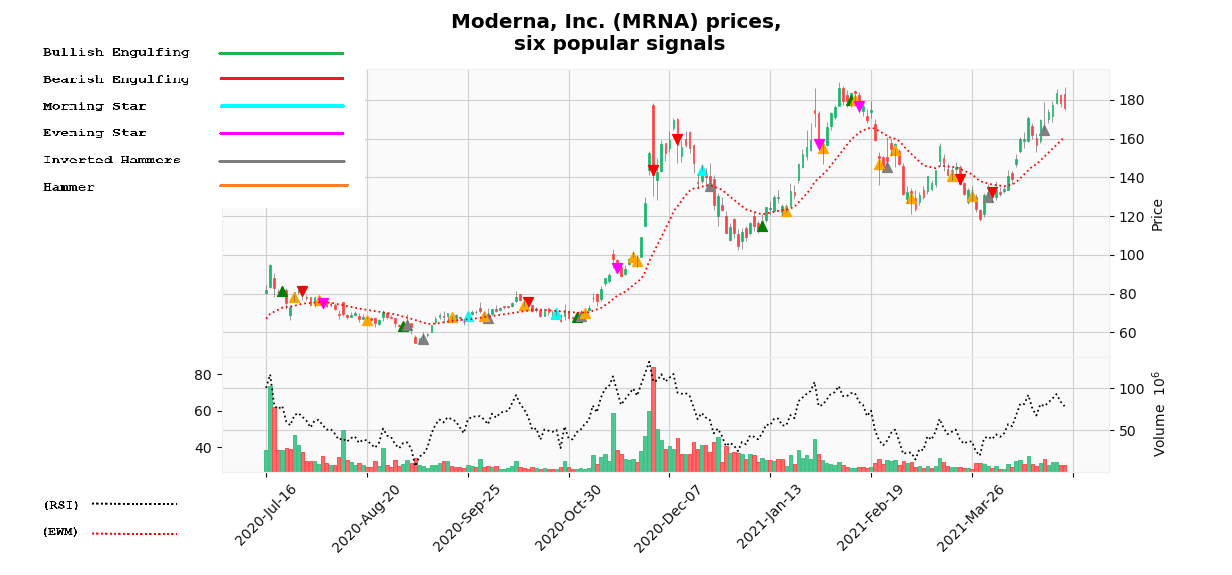

д/ Логиката продължава с генериране на показателя, чийто поведение изследваме: 
$$ HitRatio = \frac{CountSuccess}{CountSignals}$$ 

In [8]:
def get_count_of_success(signal_name, df):
    count_of_success = 0
    price_level = ''
    price_stop_coefficient = 1
    if signals_parameters[signal_name] == 'bull':
        price_level = "high"
        price_stop_coefficient = 1
    else:
        price_level = "low"
        price_stop_coefficient = -1
    for ind in df.index:
        if df[signal_name][ind] == True:  # and (df['RSI']>70 or df['RSI']<30)
            price = df[price_level][ind]
            price_stop = price + price * price_stop_coefficient * STOP_LEVEL
            idx = ind
            for i in range(1, HOLDING_PERIOD):
                date = pd.to_datetime(idx)
                try:
                    idx = next(j for j in df.index if j > date)
                    if price_stop_coefficient == 1:
                        if df[price_level][idx] >= price_stop:
                            count_of_success += 1
                            break
                    elif price_stop_coefficient == -1:
                        if df[price_level][idx] <= price_stop:
                            count_of_success += 1
                            break
                except:
                    continue
    return count_of_success


def get_signal_coefficients(signal_name, df):
    count_of_signals = len(df.loc[df[signal_name] == True])
    count_of_success = get_count_of_success(signal_name, df)
    hit_ratio = round(count_of_success / count_of_signals, 2)
    return (hit_ratio, count_of_signals, count_of_success)

е/ На последният етап от кода се правят описаните анализи и разрези на обработените данни. Тук се чертаят хистограмите на отделните сигнали, както и категорийна диаграма със средните HitRatio на отделните сигнали.

In [9]:
def plot_hit_ratio(df_coefficients):
    # TODO How STOP_LEVEL impact to hit_ratio_mean - make chart for different stop-levels
    mean_hit_ratios = {}
    combined_label = ''

    for name, data in df_coefficients.items():
        mean_hit_ratio = round(np.array(data).mean(), 2)
        mean_hit_ratios[name] = mean_hit_ratio

    for k, v in mean_hit_ratios.items():
        combined_label += f"{k} : {v}\n"

    x = [k for k in mean_hit_ratios.keys()]
    y = [v for k, v in mean_hit_ratios.items()]
    plt.figure(figsize=(15, 8))
    plt.barh(x, y, color="green", label=combined_label)
    plt.title('Hit Ratio means', fontsize=24)
    legend = plt.legend()
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    plt.ylabel('Signals', fontsize=16)
    plt.xlabel('Hit Ratio', fontsize=16)
    plt.savefig("pictures/hit_ratio_barh.png")
    plt.show()


def plot_df_coefficients_histograms(df_coefficients):
    coef = pd.DataFrame.from_dict(df_coefficients)
    for name, data in df_coefficients.items():
        c_mean = round(coef[name].mean(), 4)
        c_std = round(coef[name].std(), 4)
        c_skew = round(coef[name].skew(), 4)
        c_kurtosis = round(coef[name].kurtosis(), 4)
        statistical_indicators = f"Mean: {c_mean}\nStandard deviation: {c_std}\nSkewness: {c_skew}\nKurtosis: {c_kurtosis}"

        plt.title(f'Hit ratios {name} signal')
        plt.ylabel('Count of companies')
        plt.yticks(range(10), range(10))
        plt.xlabel('Hit Ratio')
        plt.hist(coef[name], bins=10, label=statistical_indicators)
        legend = plt.legend()
        plt.savefig(f"pictures/hit_ratios_{name}_histogram.png")
        plt.show()

Кода обработва генерираните сигнали и генерира динамично съответните графики и хистограми.

Тук е посочена примерна хистограма за сигнала InvertedHammers:

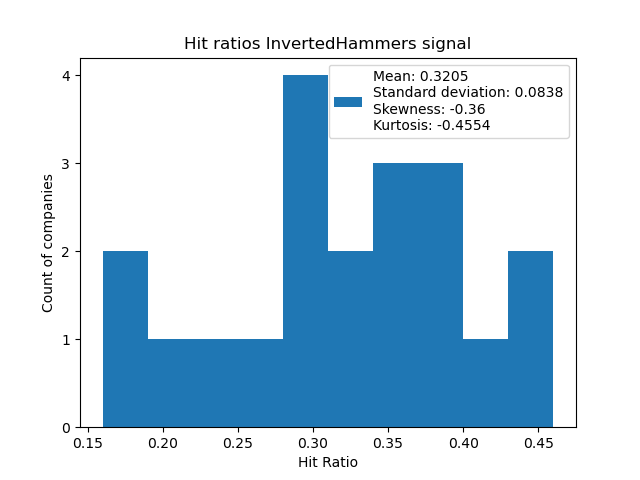

И съответната категорийна диаграма HitRatio mean на сигналите:

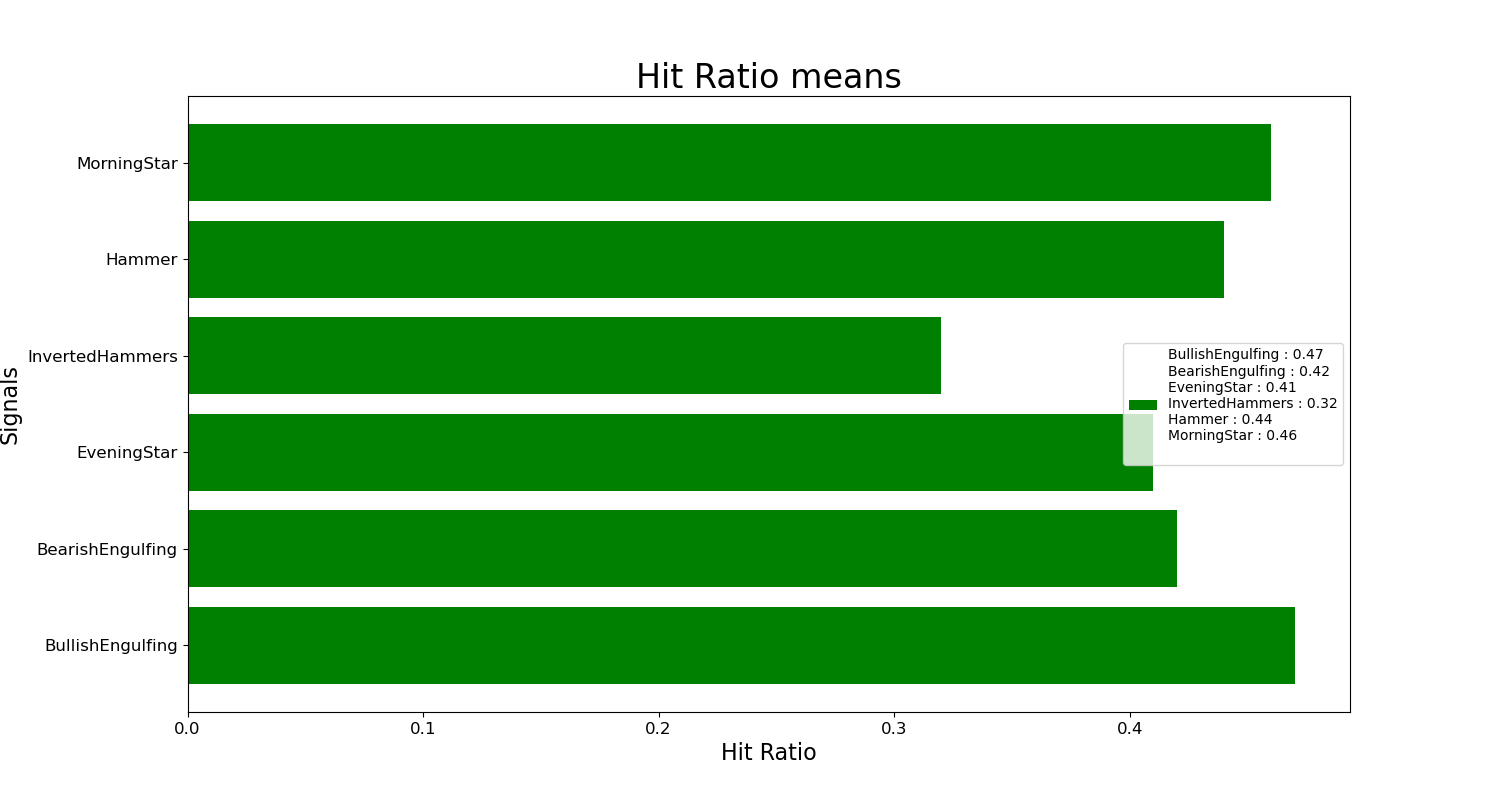







### 4. Анализ на резултатите

### TODO